In [1]:
#Importing necessary python libraries
import sqlite3
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.linear_model  import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, fbeta_score, make_scorer
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
%matplotlib inline

In [2]:
#Read in the cleaned Coronary Artery Disease (CAD) dataset.
file_path = '../Data/Cleaned Data/prepared_cad_data.csv'
cad_df = pd.read_csv(file_path)
cad_df.head()

,Age,Gender,BMI,Race,Pulse,Arrhythmia,Glu,SBP,DBP,FH_MI,DTS,Smoker,Non_HDL,DM,MI,CAD
0,69,1,26.7,4,86.0,0,554.0,113.0,74.0,0,600.0,0,102.0,1,0,0
1,54,1,28.6,3,74.0,0,219.0,157.0,61.0,0,540.0,1,120.0,1,0,0
2,72,1,28.9,3,68.0,0,183.0,142.0,82.0,1,300.0,0,66.0,1,0,0
3,73,0,19.7,3,92.0,0,104.0,137.0,87.0,1,480.0,0,116.0,0,0,0
4,56,1,41.7,1,60.0,0,104.0,157.0,82.0,0,360.0,0,188.0,0,1,1


In [3]:
#Drop MI (Miocardial Infarction (Heart Attack)) Column
cad_df.drop(columns=(['MI']), inplace=True)
cad_df2 = cad_df.drop(columns=(['FH_MI', 'Arrhythmia', 'DM']))
cad_df.head()

,Age,Gender,BMI,Race,Pulse,Arrhythmia,Glu,SBP,DBP,FH_MI,DTS,Smoker,Non_HDL,DM,CAD
0,69,1,26.7,4,86.0,0,554.0,113.0,74.0,0,600.0,0,102.0,1,0
1,54,1,28.6,3,74.0,0,219.0,157.0,61.0,0,540.0,1,120.0,1,0
2,72,1,28.9,3,68.0,0,183.0,142.0,82.0,1,300.0,0,66.0,1,0
3,73,0,19.7,3,92.0,0,104.0,137.0,87.0,1,480.0,0,116.0,0,0
4,56,1,41.7,1,60.0,0,104.0,157.0,82.0,0,360.0,0,188.0,0,1


In [4]:
#Encoding race categories to binary categories
cad_df = pd.get_dummies(cad_df, columns=(['Race']))
cad_df.head()

,Age,Gender,BMI,Pulse,Arrhythmia,Glu,SBP,DBP,FH_MI,DTS,Smoker,Non_HDL,DM,CAD,Race_1,Race_2,Race_3,Race_4,Race_5
0,69,1,26.7,86.0,0,554.0,113.0,74.0,0,600.0,0,102.0,1,0,0,0,0,1,0
1,54,1,28.6,74.0,0,219.0,157.0,61.0,0,540.0,1,120.0,1,0,0,0,1,0,0
2,72,1,28.9,68.0,0,183.0,142.0,82.0,1,300.0,0,66.0,1,0,0,0,1,0,0
3,73,0,19.7,92.0,0,104.0,137.0,87.0,1,480.0,0,116.0,0,0,0,0,1,0,0
4,56,1,41.7,60.0,0,104.0,157.0,82.0,0,360.0,0,188.0,0,1,1,0,0,0,0


In [5]:
# Define Target Variable
y = cad_df.CAD

# Drop Target Variable From Data
X = cad_df.drop(columns=('CAD'))
X.head()

,Age,Gender,BMI,Pulse,Arrhythmia,Glu,SBP,DBP,FH_MI,DTS,Smoker,Non_HDL,DM,Race_1,Race_2,Race_3,Race_4,Race_5
0,69,1,26.7,86.0,0,554.0,113.0,74.0,0,600.0,0,102.0,1,0,0,0,1,0
1,54,1,28.6,74.0,0,219.0,157.0,61.0,0,540.0,1,120.0,1,0,0,1,0,0
2,72,1,28.9,68.0,0,183.0,142.0,82.0,1,300.0,0,66.0,1,0,0,1,0,0
3,73,0,19.7,92.0,0,104.0,137.0,87.0,1,480.0,0,116.0,0,0,0,1,0,0
4,56,1,41.7,60.0,0,104.0,157.0,82.0,0,360.0,0,188.0,0,1,0,0,0,0


In [6]:
#Split Data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

smote = SMOTE()
X_train_smote, y_train_smote,  = smote.fit_resample(X_train, y_train)

print(f'Minority Class before smote: {y_train.value_counts().iloc[1]}')
print(f'Majority Class before smote: {y_train.value_counts().iloc[0]}')
print(f'Minority Class after smote: {y_train_smote.value_counts().iloc[1]}')
print(f'Majority Class after smote: {y_train_smote.value_counts().iloc[0]}')

Minority Class before smote: 171
Majority Class before smote: 3825
Minority Class after smote: 3825
Majority Class after smote: 3825


In [7]:
dt_clf = DecisionTreeClassifier()
rf_clf = RandomForestClassifier()
xgb_clf = XGBClassifier()

In [8]:

def cad_clf(classifier):
    model = classifier
    model.fit(X_train_smote, y_train_smote)
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train_smote)
    acc_train = accuracy_score(y_train_smote, y_train_pred)*100
    acc_test = accuracy_score(y_test, y_test_pred)*100
    f2_train = fbeta_score(y_train_smote, y_train_pred, beta=2.0)*100
    f2_test = fbeta_score(y_test, y_test_pred, beta=2.0)*100
    cm = confusion_matrix(y_test, y_test_pred)
    print(f'''Accuracy of Predictions on Training Data: {round(acc_train, 2)}
Accuracy of Predictions on Test Data: {round(acc_test, 2)}
                                 ''')
    print(f'''F2 Score for Training Data: {round(f2_train, 2)}
F2 Score for Test Data: {round(f2_test, 2)}
                    ''')
    print('Confusion Matrix Numbers for Test Data')
    print(' ')
    print(f'''True Negatives: {cm[0][0]}
False Negatives: {cm[1][0]}
False Positives: {cm[0][1]}
True Positives: {cm[1][1]}
 ''')
    cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    cm_disp.plot()
    plt.title(f'Confusion Matrix')
    plt.show()

Accuracy of Predictions on Training Data: 100.0
Accuracy of Predictions on Test Data: 89.86
                                 
F2 Score for Training Data: 100.0
F2 Score for Test Data: 23.73
                    
Confusion Matrix Numbers for Test Data
 
True Negatives: 1183
False Negatives: 30
False Positives: 105
True Positives: 14
 


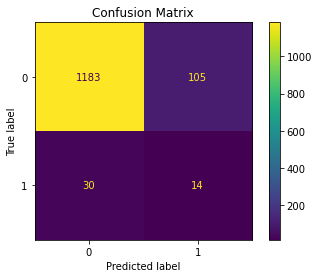

In [10]:
cad_clf(dt_clf)

In [11]:
def cad_clf_compare(clf_dict):
    classifiers = clf_dict
    for i in range(len(clf_dict)):
        print('---------------------------')
        print(list(clf_dict.keys())[i])
        print('---------------------------')
        cad_clf(list(clf_dict.values())[i])

---------------------------
Decision Tree Classifier
---------------------------
Accuracy of Predictions on Training Data: 100.0
Accuracy of Predictions on Test Data: 90.02
                                 
F2 Score for Training Data: 100.0
F2 Score for Test Data: 20.76
                    
Confusion Matrix Numbers for Test Data
 
True Negatives: 1187
False Negatives: 32
False Positives: 101
True Positives: 12
 


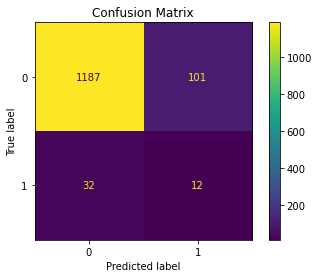

---------------------------
Random Forest Classifier
---------------------------
Accuracy of Predictions on Training Data: 100.0
Accuracy of Predictions on Test Data: 93.62
                                 
F2 Score for Training Data: 100.0
F2 Score for Test Data: 17.17
                    
Confusion Matrix Numbers for Test Data
 
True Negatives: 1239
False Negatives: 36
False Positives: 49
True Positives: 8
 


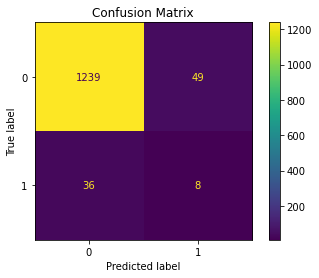

---------------------------
XGBoost Classifier
---------------------------
Accuracy of Predictions on Training Data: 100.0
Accuracy of Predictions on Test Data: 94.97
                                 
F2 Score for Training Data: 100.0
F2 Score for Test Data: 7.32
                    
Confusion Matrix Numbers for Test Data
 
True Negatives: 1262
False Negatives: 41
False Positives: 26
True Positives: 3
 


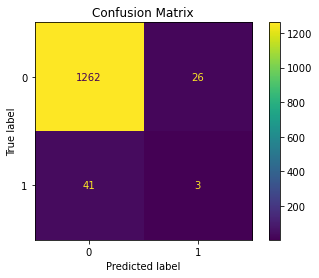

In [13]:
dt_clf = DecisionTreeClassifier()
rf_clf = RandomForestClassifier()
xgb_clf = XGBClassifier()
clf_dict = {'Decision Tree Classifier': dt_clf, 'Random Forest Classifier': rf_clf, 'XGBoost Classifier': xgb_clf}
cad_clf_compare(clf_dict)

In [14]:
def ftr_imp(model):
    n_features = X_train_smote.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train_smote.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')
    plt.show()

In [15]:
def ftr_imp_comp(clf_dict):
    for i in range(len(clf_dict)):
        print(f'                          {list(clf_dict.keys())[i]}')
        ftr_imp(list(clf_dict.values())[i])
        print('''          ----------------------------------------------------------
        ''');

                          Decision Tree Classifier


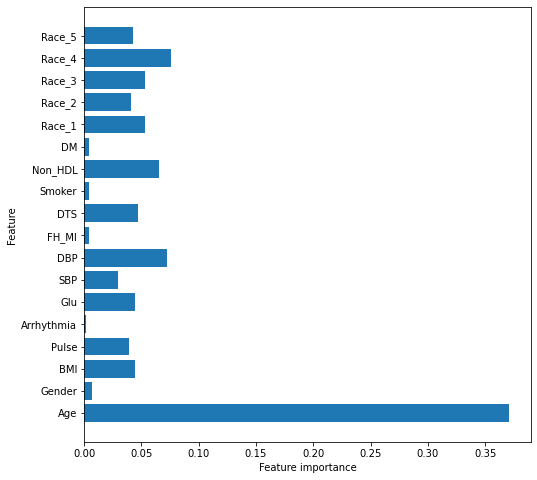

          ----------------------------------------------------------
        
                          Random Forest Classifier


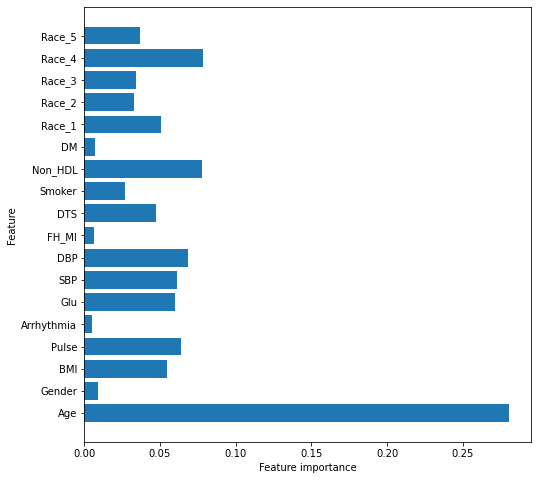

          ----------------------------------------------------------
        
                          XGBoost Classifier


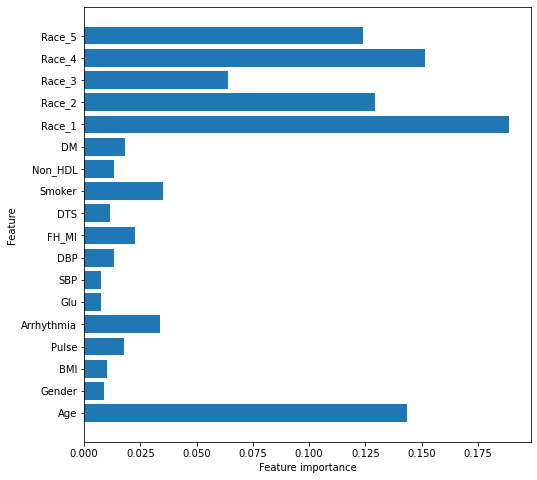

          ----------------------------------------------------------
        


In [16]:
ftr_imp_comp(clf_dict)

In [16]:
# Define Target Variable
y = cad_df2.CAD

# Drop Target Variable From Data
X = cad_df2.drop(columns=('CAD'))
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

smote = SMOTE()
X_train_smote, y_train_smote,  = smote.fit_resample(X_train, y_train)

---------------------------
Decision Tree Classifier
---------------------------
Accuracy of Predictions on Training Data: 100.0
Accuracy of Predictions on Test Data: 86.04
                                 
F2 Score for Training Data: 100.0
F2 Score for Test Data: 25.42
                    
Confusion Matrix Numbers for Test Data
 
True Negatives: 1128
False Negatives: 26
False Positives: 160
True Positives: 18
 


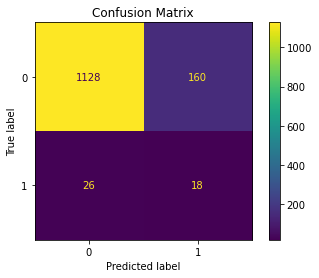

---------------------------
Random Forest Classifier
---------------------------
Accuracy of Predictions on Training Data: 100.0
Accuracy of Predictions on Test Data: 92.04
                                 
F2 Score for Training Data: 100.0
F2 Score for Test Data: 27.99
                    
Confusion Matrix Numbers for Test Data
 
True Negatives: 1211
False Negatives: 29
False Positives: 77
True Positives: 15
 


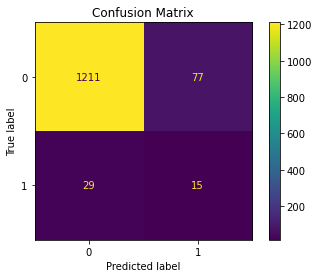

---------------------------
XGBoost Classifier
---------------------------
Accuracy of Predictions on Training Data: 99.99
Accuracy of Predictions on Test Data: 95.35
                                 
F2 Score for Training Data: 99.98
F2 Score for Test Data: 16.83
                    
Confusion Matrix Numbers for Test Data
 
True Negatives: 1263
False Negatives: 37
False Positives: 25
True Positives: 7
 


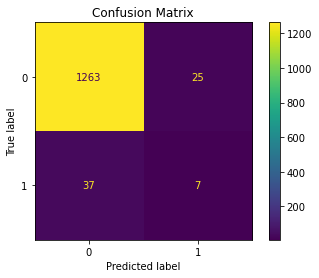

In [17]:
clf_compare(clf_dict)

In [18]:
f2_scorer = make_scorer(fbeta_score,
                          beta=2,
 greater_is_better = True)
param_grid = { 
    'criterion': ['gini', 'entropy'],
    'n_estimators': range(50,150,25),
    'max_depth': range(2,20,2),
    'max_features': ['sqrt', 'log2'],
    'min_samples_leaf': range(1,10,1),
    'min_samples_split': range(2,10,1)
}

In [25]:
rf_rs_f2 = RandomizedSearchCV(estimator=RandomForestClassifier(),
                 param_distributions=param_grid,
                 n_iter=25,
                 scoring=f2_scorer,
                 random_state=42)

# Perform the hyperparameter tuning with random search
rf_rs_f2.fit(X_train_smote, y_train_smote)

# List best parameter findings
rf_rs_f2.best_params_

{'n_estimators': 100,
 'min_samples_split': 8,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 16,
 'criterion': 'entropy'}

In [26]:
rf_hyp_opt = RandomForestClassifier(n_estimators=100, min_samples_split= 2, min_samples_leaf= 1, max_features='log2', max_depth=12, criterion='entropy')

Accuracy of Predictions on Training Data: 97.8
Accuracy of Predictions on Test Data: 88.59
                                 
F2 Score for Training Data: 99.1
F2 Score for Test Data: 30.86
                    
Confusion Matrix Numbers for Test Data
 
True Negatives: 1160
False Negatives: 24
False Positives: 128
True Positives: 20
 


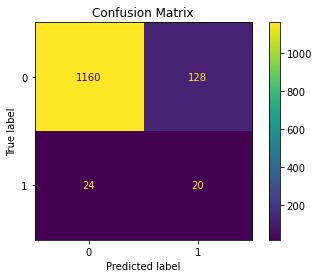

In [27]:
clf(rf_hyp_opt)